In [ ]:
"""nbconvert header

We are just configuring to hide some unnecessary warnings.
"""

import arpes.config
arpes.config.DOCS_BUILD = True

# Data Abstraction

The core data primitive in PyARPES is the `xarray.DataArray`. However, adding additional scientific functionality is needed since `xarray` provides only very general functionality. The approach that we take is described in some detail in the `xarray` documentation at [extending xarray](http://xarray.pydata.org/en/stable/internals.html#extending-xarray), which allows putting additional functionality on all arrays and datasets on particular, registered attributes.

In PyARPES we use a few of these:

1. `.S` attribute: functionality associated with spectra (physics here)
2. `.G` attribute: general abstract functionality that could reasonably be a part of xarray core
3. `.F` attribute: functionality associated with curve fitting
3. `.X` attribute: functionality related to selecting data

Caveat: In general these accessors can and do behave slightly differently between datasets and arrays, depending on what makes contextual sense.

This section will describe just some of the functionality provided by the `.S` attribute, while the following section will describe some of the functionality on `.G` and the section on curve fitting describes much of what is available through `.F` and `.X`.

Much more can be learned about them by viewing the definitions in `arpes.xarray_extensions`.

## Data selection

### `select_around` and `select_around_data`

As an alternative to interpolating, you can integrate in a small rectangular or ellipsoidal region around a point using `.S.select_around`. You can also do this for a sequence of points using `.S.select_around_data`.

These functions can be run in either summing or averaging mode using either `mode='sum'` or `mode='mean'` respectively. Using the radius parameter you can specify the integration radius in pixels (`int`) or in unitful (`float`) values for all (pass a single value) or for specific (`dict`) axes.

`select_around_data` operates in the same way, except that instead of passing a single point, `select_around_data` expects a dictionary or Dataset mapping axis names to iterable collections of coordinates.

As a concrete example, let's consider the `example_data.temperature_dependence` dataset with axes `(eV, phi, T)` consisting of cuts at different temperatures. Suppose we wish to obtain EDCs at the Fermi momentum for each value of the temperature.

First we will load the data, and combine datasets to get a full temperature dependence.

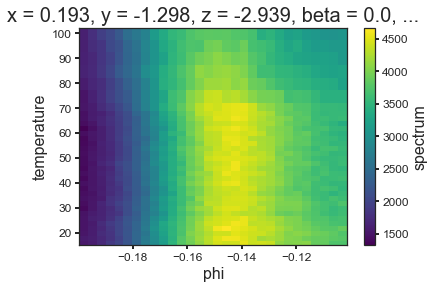

In [10]:
from arpes.io import example_data
from matplotlib import pyplot as plt

temp_dep = example_data.temperature_dependence
near_ef = temp_dep.sel(eV=slice(-0.05, 0.05), phi=slice(-0.2, None)).sum("eV")
near_ef.S.plot()

### Finding $\phi_F$/$k_F$

Now, we want to find the location of the peak in each slice of temperature so we know where to take EDCs.

We will do this in two ways:

1. Taking the argmax across `phi`
2. Curve fitting MDCs

#### Argmax

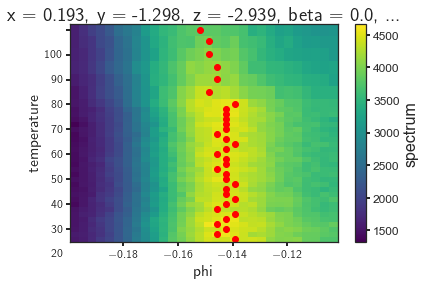

In [25]:
argmax_indices = near_ef.spectrum.argmax(dim="phi")
argmax_phis = near_ef.phi[argmax_indices]

fig, ax = plt.subplots()
near_ef.S.plot(ax=ax)
ax.scatter(*argmax_phis.G.to_arrays()[::-1], color="red")

In the process of plotting we saw another convenience function `.G.to_arrays()` which turns a 1D dataset into two plain arrays of its coordinates (X) and values (Y) so that we could scatter `phi` as a function of `temperature`.

#### Curve fitting

This might be okay depending on what we are doing, but curve fitting is also straightforward and gives better results.

In [35]:
from arpes.fits.utilities import broadcast_model
from arpes.fits.fit_models import LorentzianModel, AffineBackgroundModel

phis = broadcast_model(
    # Fit with two components, a linear background and a Lorentzian peak
    [AffineBackgroundModel, LorentzianModel],
    # fit across the entire `near_ef` dataset
    near_ef,
    # fit along each value of "temperature"
    "temperature"
)
phis

Running on multiprocessing pool... this may take a while the first time.


Fitting on pool...:   0%|          | 0/34 [00:00<?, ?it/s]

Deserializing...
Finished deserializing


<xarray.Dataset>
Dimensions:        (phi: 30, temperature: 34)
Coordinates:
  * temperature    (temperature) float64 16.0 18.0 20.0 ... 90.06 95.44 99.98
    x              float64 0.193
    y              float64 -1.298
    z              float64 -2.939
    theta          (temperature) float64 0.2273 0.2273 0.2273 ... 0.2273 0.2273
    beta           float64 0.0
    chi            float64 -0.2618
    hv             float64 55.4
    alpha          float64 1.571
    psi            int32 0
  * phi            (phi) float64 -0.1978 -0.1946 -0.1913 ... -0.1063 -0.103
Data variables:
    results        (temperature) object <lmfit.model.ModelResult object at 0x...
    data           (temperature, phi) float64 1.535e+03 1.591e+03 ... 3.066e+03
    residual       (temperature, phi) float64 -126.9 -29.14 ... 7.805 -29.28
    norm_residual  (temperature, phi) float64 -0.08268 -0.01831 ... -0.009548

There's a lot here to digest, the result of our curve fit also produced a `xr.Dataset`! This is because it bundles the fitting results (a 1D array of the fitting instances), the original data, and the residual together.

We will see more about all of this in the curve fitting section to follow. For now, let's just get the peak centers.

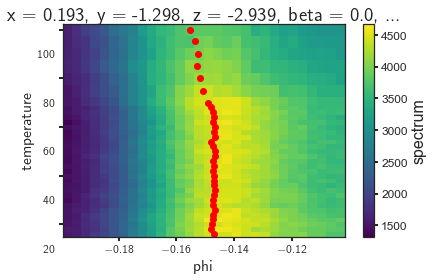

In [44]:
fig, ax = plt.subplots()
near_ef.S.plot(ax=ax)
ax.scatter(*phis.F.p("b_center").G.to_arrays()[::-1], color="red")

This looks a lot cleaner, although our peaks may be biased too far to negative `phi` due to the asymmetric background.

With the values of the Fermi momentum (in angle space) now in hand, we can select EDCs at the appropriate momentum for each value of the temperature.

Let's average in a 10 mrad window.

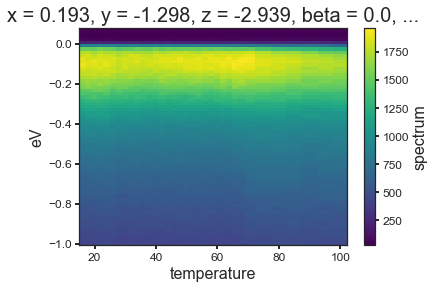

In [42]:
# take the Lorentzian (component `b`) center parameter
phi_values = phis.F.p("b_center")
temp_dep.spectrum.S.select_around_data(
    {"phi": phi_values}, mode="mean", fast=True, radius={"phi": 0.005}).S.plot()

## Exercises

1. Change the `phi` range of the selection to see how the fit responds. Can we deal with the asymmetric background this way?
2. Inspect the first fit with `phis.results[0].item()`. What can you tell about the fit?
2. Select a region of the temperature dependent data away from the band. Perform a broadcast fit for the Fermi edge using `arpes.fits.fit_models.AffineBroadenedFD`. Does the edge position shift at all? Does the edge width change at all? Look at the previous exercise to determine which parameters to look at.